# Introduction

Frequent itemsets mining algorithms are used to mine itemsets that often appear together. For instance, in the story of "Diapers and Beer", diapers and beer are analysed and found to appear together in the user's shopping basket frequently. Therefore, the diaper and beer can be seen as a frequent itemset. In this tutorial, FP-Growth algorithm is utilized to mining DBLP author cooperation. And it needs three steps to find the cooperation:
  1. process the data in DBLP dataset
  2. Analyze the  size of data
  3. Using FP-Growth Algorithm to find the author partnership

PS: 
The files related can be visited on: [file link](https://github.com/QIXUANWANG1995/15688-files-related-to-tutorial).
To run the code, you also need to download DBLP dataset by yourself. [dblp link](http://dblp.uni-trier.de/xml/).

## Introduction to DBLP Dataset

DBLP listed more than 3.66 million journal articles, conference papers, and other publications on computer science in July 2016, up from about 14,000 in 1995. All important journals on computer science are tracked. Proceedings papers of many conferences are also tracked. It is in XML format and is available at: http://dblp.uni-trier.de/xml/

Here is an article example from DBLP:
```python
   <article mdate="2017-05-28" key="journals/acta/Saxena96">
     <author>Sanjeev Saxena</author>
     <title>Parallel Integer Sorting and Simulation Amongst CRCW Models.</title>
     <pages>607-619</pages>
     <year>1996</year>
     <volume>33</volume>
     <journal>Acta Inf.</journal>
     <number>7</number>
     <url>db/journals/acta/acta33.html#Saxena96</url>
     <ee>https://doi.org/10.1007/BF03036466</ee>
   </article>
```
  
And all the author information is distributed in the first-level tags including 'article', 'inproceedings', 'proceedings', 'book','incollection', 'phdthesis', 'mastersthesis' and 'www'. Therefore, we can extract and merge all the co-authors by searching these tags. 

## Part 1: process the data in DBLP dataset

The data in DBLP dataset need to be processd and extracted the author information to build FP-tree. Python has three methods for parsing XML, SAX, DOM, and ElementTree:

1. SAX(simple API for XML): 
The python standard library contains SAX parsers. SAX uses event-driven models to process XML files by triggering events one by one during the parsing of XML and calling user-defined callbacks.

2. DOM(Document Object Model): 
XML data is parsed into a tree in memory, and XML is manipulated through the operation of the tree.

3. Element Tree: 
ElementTree is like a lightweight DOM with a convenient and friendly API. The code has good usability, fast speed, and low memory consumption.

Since the DOM needs to map XML data to a tree in memory, it is slower and consumes lots of memory. Here SAX streaming is used to read the XML file which is faster and useful. Apart from the three ways listed to parse XML, we can also  treat each line as a string and extract the author from the string. By using that method, we can also get results quickly. 

To get the authors that more appropriate for FP-growth algorithm, twelve famous conferences are selected as target conferences. And after locating the conferences including SDM, ICDM, ECML/PKDD, PAKDD, WSDM, DMKD, CVPR, ICML, NIPS, COLT, SIGIR and KDD, the first-level tag of all these conferences is "inproceedings". Therefore, the "inproceedings" is selected as the only tag used in this tutorial. Also the time range after consideration and repeated calculation, the start year is set to 2013, which has a good performance on the time and final results.

In [29]:
import codecs
from xml.sax import handler, make_parser
paper_tag = 'inproceedings'
fromYear = 2010

The idea is that when the analyzer enters one of the above attributes including author, title, pages, year..., the flag is set to 1 and the authors' names are written to the file. After that, flag is marked to 0 when exiting and authors.txt file which only contains the co-author information is obtained as results. Meanwhile, the authors are collected in a time range from 2010 to 2018.

In [30]:
class mHandler(handler.ContentHandler):
    '''
    startDocument() method is called when the document is started.
    endDocument() method is called when the parser reaches the end of the document.
    startElement(self, name, attrs) method called when an XML start tag is encountered
       name is the name of the tag. eg: author, title, pages, year...
       attrs is the tag's attribute value dictionary.
    endElement(self, name) method is called when an XML closing tag is encountered.
    '''   
    def __init__(self, result):
        self.result = result
        self.authorList = ""
        self.year = 0
        self.flag = 0
        self.tag = ""
        self.temp = ""
        
    def startDocument(self):
         print ("Document start")
         
    def endDocument(self):
         print ("Document end")
    
    def startElement(self, tag, attributes):
        if tag == paper_tag:
            self.flag = 1
            self.temp = tag
        elif self.flag == 1: #tag !="inproceedings" and self.flag==1, we are now in a subtag of "inproceedings"
            self.tag = tag
        
    def endElement(self, tag):
        if self.flag == 1 and self.temp == tag:
            if self.year >= fromYear and len(self.authorList) > 0:
                #res=[] "author1|author2|..|authorn \n"
                res = self.authorList + "\r\n"
                self.result.write(res)
            self.authorList = ""
            self.year = 0
            self.flag = 0
            self.tag = ""
            self.temp = ""
    
    def characters(self, content):
        if self.flag==1: #we are now in "inproceedings" tag
            if self.tag == "author" and len(content) > 2:
                self.authorList += content + "|"
            elif self.tag == "year" and len(content) == 4:
                self.year = int(content)
                
def parserDblpXml(source, result):
    handler = mHandler(result)
    parser = make_parser()
    parser.setContentHandler(handler)
    parser.parse(source)    

Then you can get the results of authors and if they are co-authors, they will be in one line. The following is a sample of output:
```python
 Pierre Seimandi|Guillaume Dufour|Fran|ois Rogier
 Naveen Kuppuswamy|Cristiano Alessandro
 Su-Hua Wang|Durgesh Samadhiya|Dengjie Chen
  ...
```
The result of authors are stored in a txt file named authors.txt for the future usage.

In [31]:
source = codecs.open('dblp.xml','r','utf-8')
result = codecs.open('authors.txt','w','utf-8')
parserDblpXml(source,result)
result.close()
source.close()

Document start
Document end


First, the authors obtained in step 1 are read and I suppose the same name of co-authors to be one person since the FP-Growth algorithm does not allow the same name. Then the name of collaborators is written in the authors_encoded.txt file. For example, one line like "ristiano Pierre Seimandi,Guillaume Dufour,ois Rogier,Fran" means these four authors are the co-authors in a certain paper or publication.   

In [28]:
source = codecs.open('authors.txt','r','utf-8')
result = codecs.open('authors_encoded.txt','w','utf-8')

for line in source:
    name_list = line.replace('\r\n','').split('|')
    t = set()
    for name in name_list:
        if not (name == '' or name == ' '):
            t.add(name)
    result.write((','.join(t))+'\r\n')
source.close()
result.close()
print("finished")

finished


Here, some examples of the output are listed:
```python
  Pierre Seimandi,Guillaume Dufour,ois Rogier,Fran
  Cristiano Alessandro,Naveen Kuppuswamy
  Durgesh Samadhiya,Su-Hua Wang,Dengjie Chen
```
 Each line represents a co-relationship among authors. Let's see the first line 'Fran,Guillaume Dufour,Pierre Seimandi,ois Rogier' which means five authors listed are the coauthor in one publication.

# Part 2: Analyze the  size of data

First, the number of papers or publications of every author are calculated and documented. Then we can create a coordinator system. The horizontal axis indicates the number of publications and the vertical axis indicates the number of authors that has corresponding publications. The purpose of the picture is to help us to determine an interval that is appropriate and find that threshold value. Then the support degree can be obtained for the FP-growth algorithm.

In [10]:
import codecs
import matplotlib.pyplot as plt
import numpy as np

In [12]:
def getcounts(name):
    data = codecs.open(name,'r','utf-8')
    word_counts = {}
    for line in data:
        line = line.split(',')
        for word in line[0:-1]:
            word_counts[word] = word_counts.get(word,0) + 1

    data.close()
    return word_counts

The dictionary named word_counts stores the number of occurrences of an author. The key of the dictionary is the name of author and the value is the frequency.

In [21]:
def draw(word_counts):
    bins = {}
    for k,v in word_counts.items():
        bins[v] = bins.get(v,0) + 1
    y = []
    for i in range(40, 100):
        y.append(bins.get(i,0))
    plt.grid()    
    plt.plot(y,'.')
    plt.grid()
    my_x_ticks = np.arange(40, 100, 10)
    my_y_ticks = np.arange(0, 300, 30)
    plt.xticks(np.arange(0, 60,10),my_x_ticks)
    plt.yticks(my_y_ticks)
    plt.xlabel(u'number of publications')
    plt.ylabel(u'number of authors')
    plt.title(u'relationship between authors and publications')
    plt.show()

When the number of publications is 40, the number of authors is about 300. In other words, the number of authors that have about 40 publications is about 300. After repeated, the threshold value is chose to be 40 which is neither too small that can not guarantee a good result or too large that need a high amount of calculations.

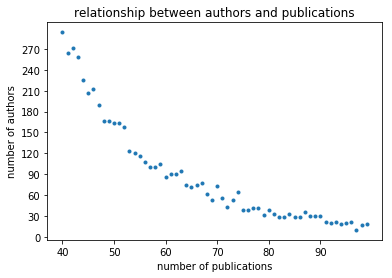

In [22]:
draw(getcounts('authors_encoded.txt'))

After executing the above code, you can get a picture below:
<img src="relationshipPic.png">

## Part 3: Using FP-Growth Algorithm to find the author partnership 

The FP-Growth Algorithm is an alternative way to find frequent itemsets without using candidate generations, thus improving performance. For so much it uses a divide-and-conquer strategy. The core of this method is the usage of a special data structure named frequent-pattern tree (FP-tree), which retains the itemset association information. In simple words, this algorithm works as follows: first it compresses the input database creating an FP-tree instance to represent frequent items. After this first step it divides the compressed database into a set of conditional databases, each one associated with one frequent pattern. Finally, each such database is mined separately. Using this strategy, the FP-Growth reduces the search costs looking for short patterns recursively and then concatenating them in the long frequent patterns, offering good selectivity.

1. Confidence of an Association Rule
The confidence of an association rule R = "X → Y" (with item sets X and Y) is the support of the set of all items that appear in the rule (here: the support of S = X ∪ Y) divided by the support of the antecedent (also called "if-part" or "body") of the rule (here X). That is,

conf(R) = 	supp(X ∪ Y) / supp(X)

2. Support of an Item Set
Let S be an item set and T the bag/multiset of all transactions under consideration. Then the absolute support (or simply the support) of the item set S is the number of transactions in T that contain S. Likewise, the relative support of S is the fraction (or percentage) of the transactions in T which contain S. That is,

supprel(S) = (|U| / |T|) *100%
here, minSupport is about 0.00035.

In [27]:
from pyspark.ml.fpm import FPGrowth  #pip install pyspark
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
import pandas as pd
import codecs

sc = SparkContext.getOrCreate('pyspark')
spark = SparkSession(sc)
result = codecs.open('authors_print.txt','w','utf-8')

data = codecs.open('authors_encoded.txt','r','utf-8')
res = []
temp = []
i = -1
for line in data:
    temp = line.replace('\r\n','').split(',')
    i += 1;
    if temp[-1] == '':
        res.append((i,temp[0:len(temp)-1]))
    else:
        res.append((i,temp))
df = spark.createDataFrame(res,["id","items"])
df.show(truncate = 100)
fpGrowth = FPGrowth(itemsCol="items", minSupport = 0.000035, minConfidence=0.3)
model = fpGrowth.fit(df)

# Display frequent itemsets.
model.freqItemsets.show(20, truncate = 100)

# Display generated association rules.
model.associationRules.show(20, truncate = 100)

+---+---------------------------------------------------------------------------------------------+
| id|                                                                                        items|
+---+---------------------------------------------------------------------------------------------+
|  0|                                        [Pierre Seimandi, Guillaume Dufour, ois Rogier, Fran]|
|  1|                                                    [Cristiano Alessandro, Naveen Kuppuswamy]|
|  2|                                               [Durgesh Samadhiya, Su-Hua Wang, Dengjie Chen]|
|  3|                                                [Guoliang Chen 0001, Ming Qi, Guangzhong Sun]|
|  4|                          [Louis J. Durlofsky, Obiajulu J. Isebor, a Ciaurri, David Echeverr]|
|  5|                                         [Vassil N. Alexandrov, Andrew Dunk, Adrian Haffegee]|
|  6|                                                     [Worrawat Engchuan, Jonathan Hoyin Chan]|


First table show all itemsets and their ids, second table shows frequent itemsets and their frequence and third table shows association rules generated with confidence above minConfidence. for example in table 2 ,second line shows that Eduardo Qui and Jaume Abella coproduce 49 times in total.
table 1:
<img src="part3_table1.png">
table 2:
<img src="part3_table2.png">
table 3:
<img src="part3_table3.png">